In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.stats import truncnorm

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import tqdm
import time
import pdb
import argparse
import sys
from shapes_loader import *
from base_model import *
import tf_homo

from demo_superpoint import SuperPointFrontend
from homography import sample_homography

In [4]:
# magicleap model
fe = SuperPointFrontend(weights_path='superpoint_v1.pth',
                        nms_dist=4,
                        conf_thresh=1,
                        nn_thresh=10,
                        cuda=True)
#  model
model = SuperPointNet().cuda()
model = torch.load('./Fri Nov  9 15:54:21 2018/e_405_a_10.9042.model').cuda()
model.eval()

criterion = nn.Softmax(dim=1) #reduction='elementwise_sum')

W = 500
H = 400

clr_imgs = Image.open('../hpatches-dataset/img/images.png').resize((W*6,H),Image.ANTIALIAS)
# clr_imgs = Image.open('../tesrt/qc_left_br_023_1481830517.76.png').resize((W,H),Image.ANTIALIAS)
# clr_imgs_2 = Image.open('../tesrt/qc_left_br_030_1481830521.45.png').resize((W,H),Image.ANTIALIAS)

img1 = np.array(clr_imgs)
img1 = img1[:H,:W]
clr_img1 = Image.fromarray(img1)
img1 = np.array(clr_img1.convert('L'))


#img2 = np.array(clr_imgs_2)
img2 = np.array(clr_imgs)
img2 = img2[:H,W:2*W]
clr_img2 = Image.fromarray(img2)
img2 = np.array(clr_img2.convert('L'))

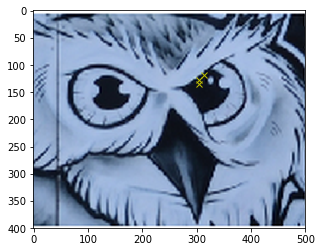

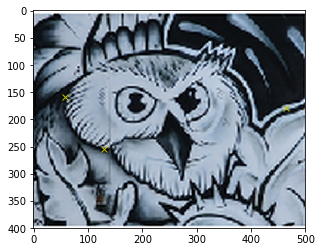

In [6]:
# magic leap model
pt_1, desc_1, _ = fe.run(img1.astype('float32'))
pt_2, desc_2, _ = fe.run(img2.astype('float32'))

fig=plt.figure()
plt.imshow(clr_img1)
plt.plot(pt_1[0,:],pt_1[1,:],'xy')

fig=plt.figure()
plt.imshow(clr_img2)
plt.plot(pt_2[0,:],pt_2[1,:],'xy')


In [7]:
probs_1, desc_1 = model(torch.from_numpy(img1).unsqueeze(0).unsqueeze(1).float().cuda())
probs_2, desc_2 = model(torch.from_numpy(img2).unsqueeze(0).unsqueeze(1).float().cuda())

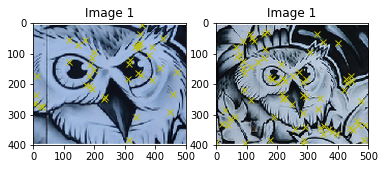

In [8]:
# show results
threshold = 0.2
fig=plt.figure()
fig.add_subplot(1, 2, 1, title='Image 1')
plt.imshow(clr_img1)
ipt_sm_1 = criterion(probs_1)
ipt_sm_1 = ipt_sm_1[:,:-1,:,:]
#find the max entry and confidence
idx_conf_1, idx_locs_1 = ipt_sm_1.max(dim=1)
idx_mask_1 = idx_conf_1 > threshold
px = []
py = []
for x in range(probs_1.shape[2]):
    for y in range(probs_1.shape[3]):
        if idx_mask_1[0,x,y] == 1:
            #location in the image
            x_ = x*8 +(idx_locs_1[0,x,y]/8)
            y_ = y*8 + (idx_locs_1[0,x,y]%8)
            px.append(x_.item())
            py.append(y_.item())
plt.plot(py,px,'xy')
# img 2
fig.add_subplot(1, 2, 2, title='Image 1')
plt.imshow(clr_img2)
ipt_sm_1 = criterion(probs_2)
ipt_sm_1 = ipt_sm_1[:,:-1,:,:]
#find the max entry and confidence
idx_conf_1, idx_locs_1 = ipt_sm_1.max(dim=1)
idx_mask_1 = idx_conf_1 > threshold
px = []
py = []
for x in range(probs_1.shape[2]):
    for y in range(probs_1.shape[3]):
        if idx_mask_1[0,x,y] == 1:
            #location in the image
            x_ = x*8 +(idx_locs_1[0,x,y]/8)
            y_ = y*8 + (idx_locs_1[0,x,y]%8)
            px.append(x_.item())
            py.append(y_.item())
plt.plot(py,px,'xy')

290


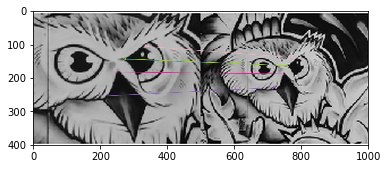

(<matplotlib.image.AxesImage at 0x7fee6845ec50>, None)

In [11]:
# see opencv
img_1_cv = cv2.imread('../tesrt/qc_left_br_023_1481830517.76.png',0)
img_2_cv = cv2.imread('../tesrt/qc_left_br_030_1481830521.45.png',0)
img_1_cv = img1
img_2_cv = img2

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img_1_cv, None)
kp2, des2 = orb.detectAndCompute(img_2_cv, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

print(len(matches))

# Draw first 10 matches.
img3 = cv2.drawMatches(img_1_cv,kp1,img_2_cv,kp2,matches[:5],None, flags=2)

plt.imshow(img3),plt.show()